# 付録A15: ネットワークの頑健性（Network Robustness）

## 学習目標

この章では、ネットワークの頑健性について学びます：

1. **頑健性の概念** - ネットワークが障害や攻撃に対してどれだけ耐えられるか
2. **ランダム障害と標的攻撃** - 異なる障害モードの影響
3. **パーコレーション理論** - 臨界閾値と相転移
4. **カスケード障害** - 連鎖的な障害の伝播
5. **ネットワーク構造と頑健性** - スケールフリー vs ランダムネットワーク

## A15.1 セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import japanize_matplotlib

plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

np.random.seed(42)
random.seed(42)

print("セットアップ完了")

セットアップ完了


## A15.2 ネットワークの頑健性とは

### 頑健性（Robustness）の定義

ネットワークの頑健性とは、ノードやエッジが除去されたときに、ネットワークがその機能や構造的特性を維持する能力を指します。

### 障害の種類

1. **ランダム障害（Random Failure）**
   - ノードやエッジがランダムに故障
   - 例：機器の偶発的故障、自然災害

2. **標的攻撃（Targeted Attack）**
   - 重要なノードを意図的に攻撃
   - 例：サイバー攻撃、テロ

### 頑健性の測定指標

1. **最大連結成分のサイズ（Giant Component Size）**
2. **ネットワーク効率（Global Efficiency）**
3. **平均経路長（Average Path Length）**
4. **臨界閾値（Critical Threshold）**

In [2]:
def get_largest_component_size(G):
    """最大連結成分の相対サイズを計算"""
    if len(G) == 0:
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc) / len(G)

def get_global_efficiency(G):
    """グローバル効率を計算"""
    if len(G) < 2:
        return 0
    return nx.global_efficiency(G)

# サンプルネットワークで確認
G = nx.barabasi_albert_graph(100, 3)

print(f"ノード数: {G.number_of_nodes()}")
print(f"エッジ数: {G.number_of_edges()}")
print(f"最大連結成分の相対サイズ: {get_largest_component_size(G):.3f}")
print(f"グローバル効率: {get_global_efficiency(G):.3f}")

ノード数: 100
エッジ数: 291
最大連結成分の相対サイズ: 1.000
グローバル効率: 0.437


## A15.3 ランダム障害のシミュレーション

ランダム障害では、ノードがランダムに選ばれて除去されます。

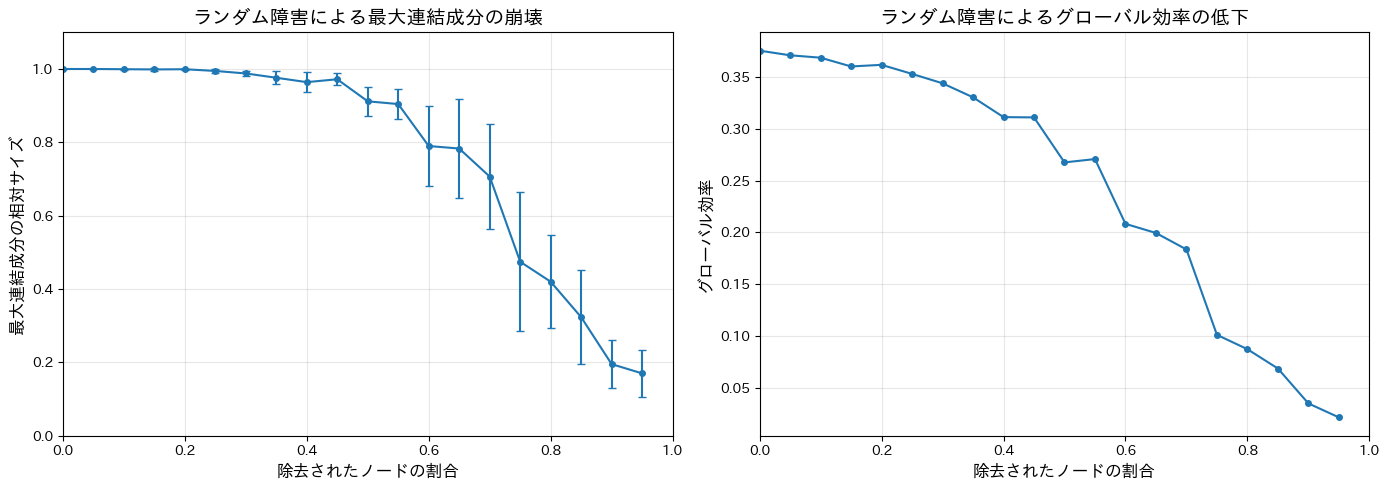

In [3]:
def simulate_random_failure(G, removal_fraction):
    """
    ランダム障害をシミュレート
    
    Parameters:
    -----------
    G : networkx.Graph
        元のグラフ
    removal_fraction : float
        除去するノードの割合 (0-1)
    
    Returns:
    --------
    networkx.Graph
        ノード除去後のグラフ
    """
    G_copy = G.copy()
    n_remove = int(len(G_copy) * removal_fraction)
    
    # ランダムにノードを選択して除去
    nodes_to_remove = random.sample(list(G_copy.nodes()), n_remove)
    G_copy.remove_nodes_from(nodes_to_remove)
    
    return G_copy

def analyze_random_failure(G, steps=20, n_trials=10):
    """
    ランダム障害の影響を分析
    
    Parameters:
    -----------
    G : networkx.Graph
        分析対象のグラフ
    steps : int
        除去割合のステップ数
    n_trials : int
        各ステップでの試行回数
    """
    fractions = np.linspace(0, 0.95, steps)
    gc_sizes = []
    gc_stds = []
    efficiencies = []
    
    for f in fractions:
        gc_trial = []
        eff_trial = []
        
        for _ in range(n_trials):
            G_damaged = simulate_random_failure(G, f)
            if len(G_damaged) > 0:
                gc_trial.append(get_largest_component_size(G_damaged))
                eff_trial.append(get_global_efficiency(G_damaged))
            else:
                gc_trial.append(0)
                eff_trial.append(0)
        
        gc_sizes.append(np.mean(gc_trial))
        gc_stds.append(np.std(gc_trial))
        efficiencies.append(np.mean(eff_trial))
    
    return fractions, gc_sizes, gc_stds, efficiencies

# スケールフリーネットワークでテスト
G_sf = nx.barabasi_albert_graph(200, 3)
fractions, gc_sizes, gc_stds, efficiencies = analyze_random_failure(G_sf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 最大連結成分サイズ
axes[0].errorbar(fractions, gc_sizes, yerr=gc_stds, capsize=3, marker='o', markersize=4)
axes[0].set_xlabel('除去されたノードの割合', fontsize=12)
axes[0].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
axes[0].set_title('ランダム障害による最大連結成分の崩壊', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1.1)

# グローバル効率
axes[1].plot(fractions, efficiencies, 'o-', markersize=4)
axes[1].set_xlabel('除去されたノードの割合', fontsize=12)
axes[1].set_ylabel('グローバル効率', fontsize=12)
axes[1].set_title('ランダム障害によるグローバル効率の低下', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## A15.4 標的攻撃のシミュレーション

標的攻撃では、最も重要なノード（通常は次数が高いノード）から順に除去されます。

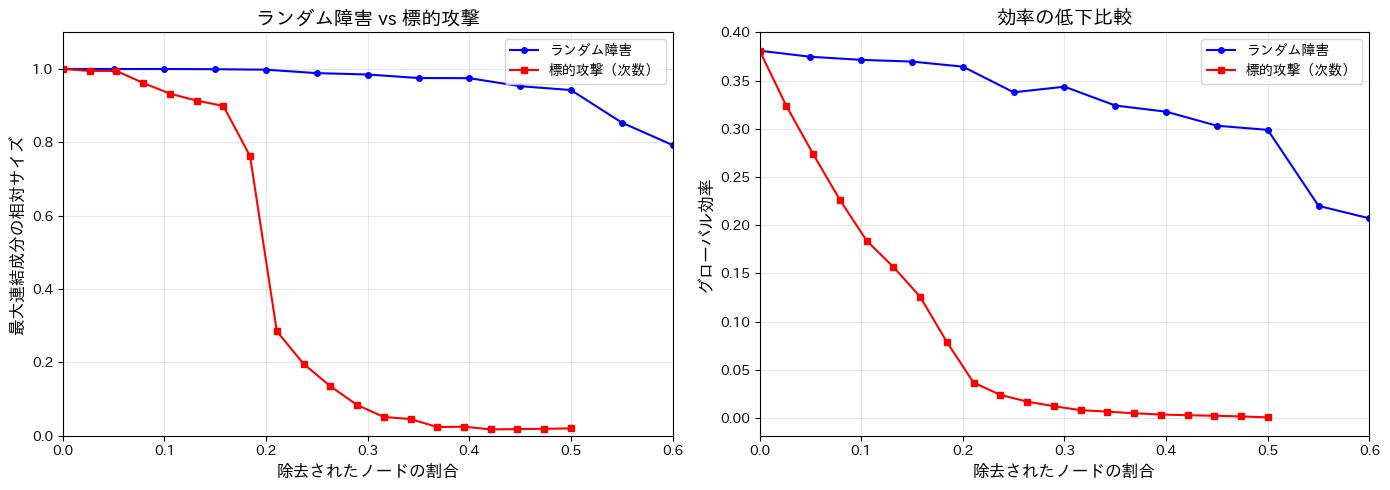

スケールフリーネットワークの特徴:
- ランダム障害には強い耐性を持つ
- 標的攻撃には非常に脆弱


In [4]:
def simulate_targeted_attack(G, removal_fraction, attack_strategy='degree'):
    """
    標的攻撃をシミュレート
    
    Parameters:
    -----------
    G : networkx.Graph
        元のグラフ
    removal_fraction : float
        除去するノードの割合 (0-1)
    attack_strategy : str
        攻撃戦略 ('degree', 'betweenness', 'eigenvector')
    """
    G_copy = G.copy()
    n_remove = int(len(G) * removal_fraction)
    
    for _ in range(n_remove):
        if len(G_copy) == 0:
            break
        
        # 攻撃戦略に基づいてノードをランク付け
        if attack_strategy == 'degree':
            centrality = dict(G_copy.degree())
        elif attack_strategy == 'betweenness':
            centrality = nx.betweenness_centrality(G_copy)
        elif attack_strategy == 'eigenvector':
            try:
                centrality = nx.eigenvector_centrality(G_copy, max_iter=1000)
            except:
                centrality = dict(G_copy.degree())
        else:
            centrality = dict(G_copy.degree())
        
        # 最も重要なノードを除去
        target = max(centrality, key=centrality.get)
        G_copy.remove_node(target)
    
    return G_copy

def analyze_targeted_attack(G, steps=20, attack_strategy='degree'):
    """
    標的攻撃の影響を分析
    """
    fractions = np.linspace(0, 0.5, steps)  # 標的攻撃は少ない除去で大きな影響
    gc_sizes = []
    efficiencies = []
    
    for f in fractions:
        G_damaged = simulate_targeted_attack(G, f, attack_strategy)
        if len(G_damaged) > 0:
            gc_sizes.append(get_largest_component_size(G_damaged))
            efficiencies.append(get_global_efficiency(G_damaged))
        else:
            gc_sizes.append(0)
            efficiencies.append(0)
    
    return fractions, gc_sizes, efficiencies

# 次数ベースの標的攻撃
G_sf = nx.barabasi_albert_graph(200, 3)
fractions_t, gc_sizes_t, efficiencies_t = analyze_targeted_attack(G_sf, attack_strategy='degree')

# ランダム障害との比較
fractions_r, gc_sizes_r, gc_stds_r, efficiencies_r = analyze_random_failure(G_sf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 最大連結成分サイズ
axes[0].plot(fractions_r, gc_sizes_r, 'b-o', label='ランダム障害', markersize=4)
axes[0].plot(fractions_t, gc_sizes_t, 'r-s', label='標的攻撃（次数）', markersize=4)
axes[0].set_xlabel('除去されたノードの割合', fontsize=12)
axes[0].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
axes[0].set_title('ランダム障害 vs 標的攻撃', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 0.6)
axes[0].set_ylim(0, 1.1)

# グローバル効率
axes[1].plot(fractions_r[:len(fractions_t)], efficiencies_r[:len(fractions_t)], 'b-o', label='ランダム障害', markersize=4)
axes[1].plot(fractions_t, efficiencies_t, 'r-s', label='標的攻撃（次数）', markersize=4)
axes[1].set_xlabel('除去されたノードの割合', fontsize=12)
axes[1].set_ylabel('グローバル効率', fontsize=12)
axes[1].set_title('効率の低下比較', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 0.6)

plt.tight_layout()
plt.show()

print("スケールフリーネットワークの特徴:")
print("- ランダム障害には強い耐性を持つ")
print("- 標的攻撃には非常に脆弱")

## A15.5 異なるネットワーク構造の比較

ネットワークの構造によって、頑健性は大きく異なります。

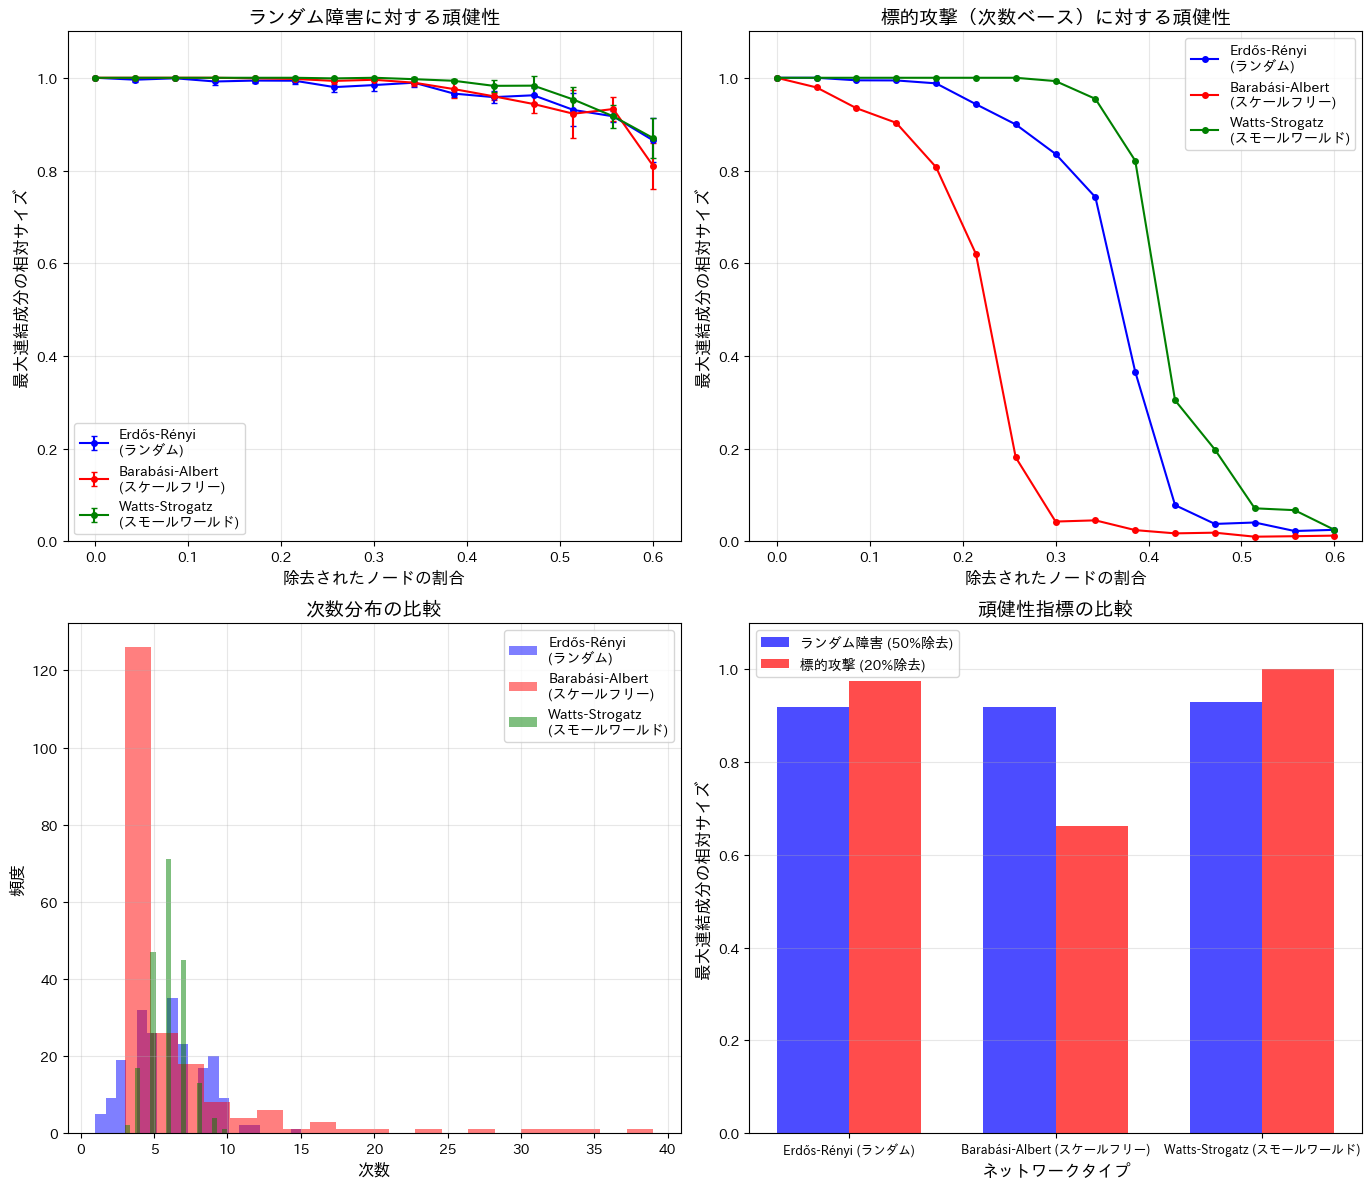


【ネットワーク構造と頑健性の関係】

スケールフリーネットワーク:
  - ランダム障害に強い（ハブの除去確率が低い）
  - 標的攻撃に弱い（ハブを狙われると崩壊）

ランダムネットワーク:
  - ランダム障害・標的攻撃に対して同程度の脆弱性
  - 均質な構造のため、どのノードを除去しても影響は同程度

スモールワールドネットワーク:
  - 中間的な頑健性
  - 局所的なクラスタリングが障害の影響を緩和


In [5]:
def compare_network_robustness(n_nodes=200, n_trials=5):
    """
    異なるネットワーク構造の頑健性を比較
    """
    # 異なるタイプのネットワークを生成
    networks = {
        'Erdős-Rényi\n(ランダム)': nx.erdos_renyi_graph(n_nodes, 0.03),
        'Barabási-Albert\n(スケールフリー)': nx.barabasi_albert_graph(n_nodes, 3),
        'Watts-Strogatz\n(スモールワールド)': nx.watts_strogatz_graph(n_nodes, 6, 0.3),
    }
    
    fractions = np.linspace(0, 0.6, 15)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    colors = ['blue', 'red', 'green']
    
    # ランダム障害
    for idx, (name, G) in enumerate(networks.items()):
        gc_means = []
        gc_stds = []
        
        for f in fractions:
            gc_trial = []
            for _ in range(n_trials):
                G_damaged = simulate_random_failure(G, f)
                if len(G_damaged) > 0:
                    gc_trial.append(get_largest_component_size(G_damaged))
                else:
                    gc_trial.append(0)
            gc_means.append(np.mean(gc_trial))
            gc_stds.append(np.std(gc_trial))
        
        axes[0, 0].errorbar(fractions, gc_means, yerr=gc_stds, 
                           label=name, color=colors[idx], capsize=2, marker='o', markersize=4)
    
    axes[0, 0].set_xlabel('除去されたノードの割合', fontsize=12)
    axes[0, 0].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
    axes[0, 0].set_title('ランダム障害に対する頑健性', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1.1)
    
    # 標的攻撃（次数ベース）
    for idx, (name, G) in enumerate(networks.items()):
        gc_sizes = []
        
        for f in fractions:
            G_damaged = simulate_targeted_attack(G, f, 'degree')
            if len(G_damaged) > 0:
                gc_sizes.append(get_largest_component_size(G_damaged))
            else:
                gc_sizes.append(0)
        
        axes[0, 1].plot(fractions, gc_sizes, 'o-', 
                       label=name, color=colors[idx], markersize=4)
    
    axes[0, 1].set_xlabel('除去されたノードの割合', fontsize=12)
    axes[0, 1].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
    axes[0, 1].set_title('標的攻撃（次数ベース）に対する頑健性', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1.1)
    
    # 次数分布の比較
    for idx, (name, G) in enumerate(networks.items()):
        degrees = [d for n, d in G.degree()]
        axes[1, 0].hist(degrees, bins=20, alpha=0.5, label=name, color=colors[idx])
    
    axes[1, 0].set_xlabel('次数', fontsize=12)
    axes[1, 0].set_ylabel('頻度', fontsize=12)
    axes[1, 0].set_title('次数分布の比較', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 頑健性指標のまとめ
    summary_data = []
    for name, G in networks.items():
        # 50%のノード除去後の頑健性
        G_random = simulate_random_failure(G, 0.5)
        G_targeted = simulate_targeted_attack(G, 0.2)  # 標的攻撃は少ない除去で測定
        
        random_gc = get_largest_component_size(G_random) if len(G_random) > 0 else 0
        targeted_gc = get_largest_component_size(G_targeted) if len(G_targeted) > 0 else 0
        
        summary_data.append({
            'name': name.replace('\n', ' '),
            'random': random_gc,
            'targeted': targeted_gc
        })
    
    x = np.arange(len(summary_data))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, [d['random'] for d in summary_data], width, label='ランダム障害 (50%除去)', color='blue', alpha=0.7)
    axes[1, 1].bar(x + width/2, [d['targeted'] for d in summary_data], width, label='標的攻撃 (20%除去)', color='red', alpha=0.7)
    
    axes[1, 1].set_xlabel('ネットワークタイプ', fontsize=12)
    axes[1, 1].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
    axes[1, 1].set_title('頑健性指標の比較', fontsize=14)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([d['name'] for d in summary_data], fontsize=9)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

compare_network_robustness()

print("\n【ネットワーク構造と頑健性の関係】")
print("")
print("スケールフリーネットワーク:")
print("  - ランダム障害に強い（ハブの除去確率が低い）")
print("  - 標的攻撃に弱い（ハブを狙われると崩壊）")
print("")
print("ランダムネットワーク:")
print("  - ランダム障害・標的攻撃に対して同程度の脆弱性")
print("  - 均質な構造のため、どのノードを除去しても影響は同程度")
print("")
print("スモールワールドネットワーク:")
print("  - 中間的な頑健性")
print("  - 局所的なクラスタリングが障害の影響を緩和")

## A15.6 パーコレーション理論と臨界閾値

パーコレーション理論は、ネットワークの連結性が失われる臨界点を予測します。

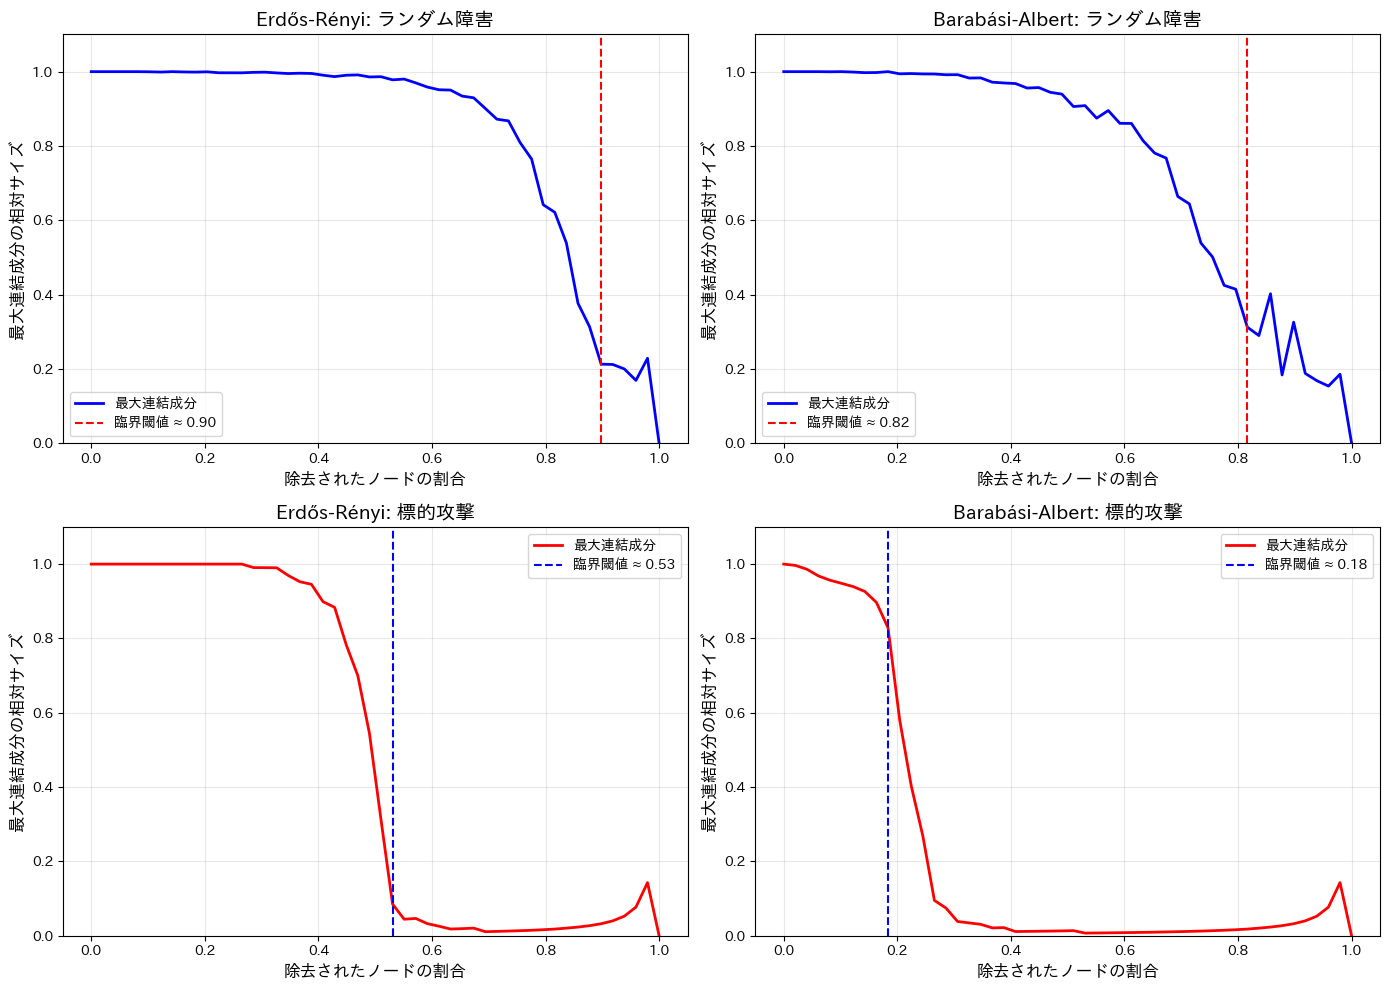

【臨界閾値の理論的背景】

ランダムネットワークのランダム障害に対する臨界閾値:
  fc = 1 - 1/<k>  （<k>は平均次数）

スケールフリーネットワーク（γ < 3）のランダム障害:
  理論上、fc → 1（ほぼすべてのノードを除去しても連結性が維持）
  これはハブの存在により、ネットワークが非常に頑健であることを示す


In [6]:
def find_percolation_threshold(G, attack_type='random', n_trials=10, precision=50):
    """
    パーコレーション閾値を見つける
    
    Parameters:
    -----------
    G : networkx.Graph
        分析対象のグラフ
    attack_type : str
        'random' または 'targeted'
    n_trials : int
        試行回数
    precision : int
        探索の精度（ステップ数）
    
    Returns:
    --------
    float
        推定された臨界閾値
    """
    fractions = np.linspace(0, 1, precision)
    gc_sizes = []
    second_derivatives = []
    
    for f in fractions:
        if attack_type == 'random':
            gc_trial = []
            for _ in range(n_trials):
                G_damaged = simulate_random_failure(G, f)
                if len(G_damaged) > 0:
                    gc_trial.append(get_largest_component_size(G_damaged))
                else:
                    gc_trial.append(0)
            gc_sizes.append(np.mean(gc_trial))
        else:
            G_damaged = simulate_targeted_attack(G, f, 'degree')
            if len(G_damaged) > 0:
                gc_sizes.append(get_largest_component_size(G_damaged))
            else:
                gc_sizes.append(0)
    
    # 二次微分（変化率の変化）を計算して臨界点を推定
    gc_array = np.array(gc_sizes)
    first_derivative = np.gradient(gc_array)
    second_derivative = np.gradient(first_derivative)
    
    # 二次微分の絶対値が最大の点が臨界閾値
    # ただし、最初と最後の点は除外
    critical_idx = np.argmax(np.abs(second_derivative[2:-2])) + 2
    critical_threshold = fractions[critical_idx]
    
    return critical_threshold, fractions, gc_sizes, second_derivative

# 異なるネットワークで臨界閾値を比較
n_nodes = 300

networks = {
    'Erdős-Rényi': nx.erdos_renyi_graph(n_nodes, 0.03),
    'Barabási-Albert': nx.barabasi_albert_graph(n_nodes, 3),
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (name, G) in enumerate(networks.items()):
    # ランダム障害
    threshold_r, fractions_r, gc_r, deriv_r = find_percolation_threshold(G, 'random')
    axes[0, idx].plot(fractions_r, gc_r, 'b-', linewidth=2, label='最大連結成分')
    axes[0, idx].axvline(x=threshold_r, color='r', linestyle='--', label=f'臨界閾値 ≈ {threshold_r:.2f}')
    axes[0, idx].set_xlabel('除去されたノードの割合', fontsize=12)
    axes[0, idx].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
    axes[0, idx].set_title(f'{name}: ランダム障害', fontsize=14)
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    axes[0, idx].set_ylim(0, 1.1)
    
    # 標的攻撃
    threshold_t, fractions_t, gc_t, deriv_t = find_percolation_threshold(G, 'targeted')
    axes[1, idx].plot(fractions_t, gc_t, 'r-', linewidth=2, label='最大連結成分')
    axes[1, idx].axvline(x=threshold_t, color='b', linestyle='--', label=f'臨界閾値 ≈ {threshold_t:.2f}')
    axes[1, idx].set_xlabel('除去されたノードの割合', fontsize=12)
    axes[1, idx].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
    axes[1, idx].set_title(f'{name}: 標的攻撃', fontsize=14)
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)
    axes[1, idx].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("【臨界閾値の理論的背景】")
print("")
print("ランダムネットワークのランダム障害に対する臨界閾値:")
print("  fc = 1 - 1/<k>  （<k>は平均次数）")
print("")
print("スケールフリーネットワーク（γ < 3）のランダム障害:")
print("  理論上、fc → 1（ほぼすべてのノードを除去しても連結性が維持）")
print("  これはハブの存在により、ネットワークが非常に頑健であることを示す")

## A15.7 カスケード障害

カスケード障害は、一つのノードの障害が他のノードに連鎖的に広がる現象です。

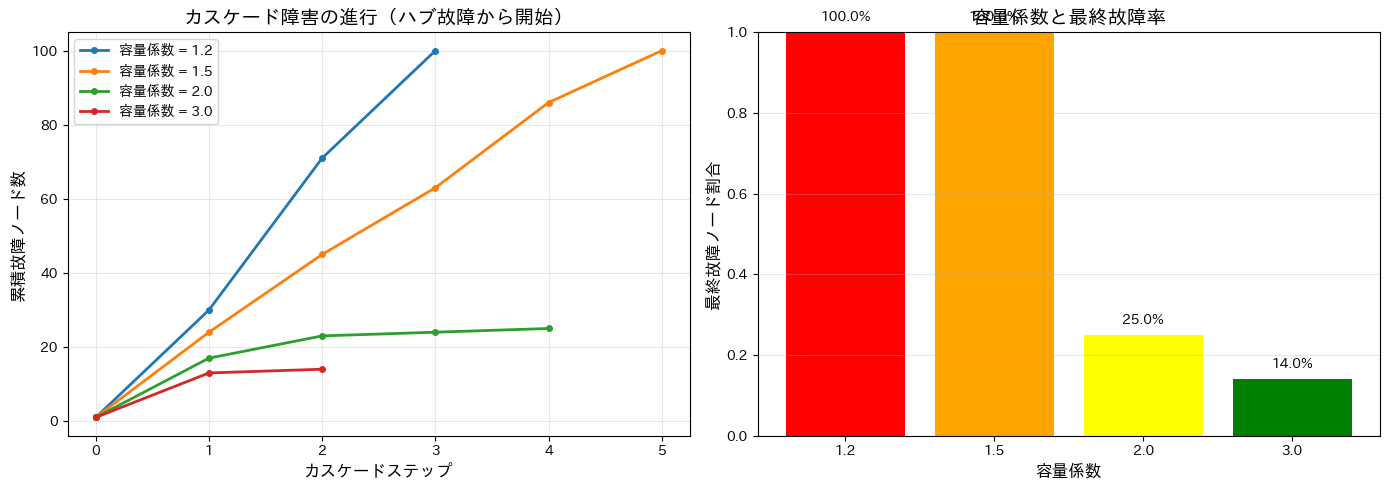

【カスケード障害の特徴】

・容量係数が小さいほど、カスケードが発生しやすい
・ハブの故障は大規模なカスケードを引き起こす可能性が高い
・十分な余裕容量があれば、カスケードを防止できる


In [7]:
def simulate_cascade_failure(G, initial_failure, capacity_factor=1.5, load_redistribution='neighbors'):
    """
    カスケード障害をシミュレート
    
    各ノードには容量（capacity）があり、負荷（load）が容量を超えると故障する。
    故障したノードの負荷は隣接ノードに再分配される。
    
    Parameters:
    -----------
    G : networkx.Graph
        元のグラフ
    initial_failure : node
        最初に故障するノード
    capacity_factor : float
        容量係数（初期負荷に対する容量の比率）
    load_redistribution : str
        負荷再分配の方法 ('neighbors', 'global')
    
    Returns:
    --------
    list
        各ステップでの故障ノード数の履歴
    set
        最終的に故障したノードの集合
    """
    G_copy = G.copy()
    
    # 初期負荷と容量を設定（媒介中心性をベースに）
    betweenness = nx.betweenness_centrality(G_copy)
    
    load = {node: betweenness[node] for node in G_copy.nodes()}
    capacity = {node: load[node] * capacity_factor for node in G_copy.nodes()}
    
    failed_nodes = set()
    cascade_history = []
    
    # 初期故障
    nodes_to_fail = {initial_failure}
    
    step = 0
    while nodes_to_fail:
        # 故障ノードを記録
        cascade_history.append(len(nodes_to_fail))
        
        for node in nodes_to_fail:
            failed_nodes.add(node)
            
            if node in G_copy:
                # 故障ノードの負荷を再分配
                node_load = load.get(node, 0)
                neighbors = list(G_copy.neighbors(node))
                
                if load_redistribution == 'neighbors' and neighbors:
                    # 隣接ノードに均等に分配
                    load_per_neighbor = node_load / len(neighbors)
                    for neighbor in neighbors:
                        if neighbor not in failed_nodes:
                            load[neighbor] = load.get(neighbor, 0) + load_per_neighbor
                
                # ノードを除去
                G_copy.remove_node(node)
        
        # 次のステップで故障するノードを特定
        nodes_to_fail = set()
        for node in G_copy.nodes():
            if node not in failed_nodes and load.get(node, 0) > capacity.get(node, 0):
                nodes_to_fail.add(node)
        
        step += 1
        if step > len(G):  # 無限ループ防止
            break
    
    return cascade_history, failed_nodes, G_copy

# カスケード障害のデモ
G = nx.barabasi_albert_graph(100, 3)

# 次数が最も高いノード（ハブ）を特定
hub = max(G.degree(), key=lambda x: x[1])[0]

# 異なる容量係数でカスケード障害をシミュレート
capacity_factors = [1.2, 1.5, 2.0, 3.0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cascade_results = {}
for cf in capacity_factors:
    history, failed, G_final = simulate_cascade_failure(G, hub, capacity_factor=cf)
    cascade_results[cf] = {
        'history': history,
        'total_failed': len(failed),
        'cascade_steps': len(history)
    }
    
    # カスケードの進行を表示
    cumulative = np.cumsum(history)
    axes[0].plot(range(len(cumulative)), cumulative, 'o-', 
                label=f'容量係数 = {cf}', linewidth=2, markersize=4)

axes[0].set_xlabel('カスケードステップ', fontsize=12)
axes[0].set_ylabel('累積故障ノード数', fontsize=12)
axes[0].set_title('カスケード障害の進行（ハブ故障から開始）', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 最終的な故障割合
x_pos = np.arange(len(capacity_factors))
failure_rates = [cascade_results[cf]['total_failed'] / len(G) for cf in capacity_factors]
bars = axes[1].bar(x_pos, failure_rates, color=['red', 'orange', 'yellow', 'green'])
axes[1].set_xlabel('容量係数', fontsize=12)
axes[1].set_ylabel('最終故障ノード割合', fontsize=12)
axes[1].set_title('容量係数と最終故障率', fontsize=14)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([str(cf) for cf in capacity_factors])
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, rate in zip(bars, failure_rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rate:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("【カスケード障害の特徴】")
print("")
print("・容量係数が小さいほど、カスケードが発生しやすい")
print("・ハブの故障は大規模なカスケードを引き起こす可能性が高い")
print("・十分な余裕容量があれば、カスケードを防止できる")

## A15.8 頑健性強化戦略

ネットワークの頑健性を向上させるための戦略を検討します。

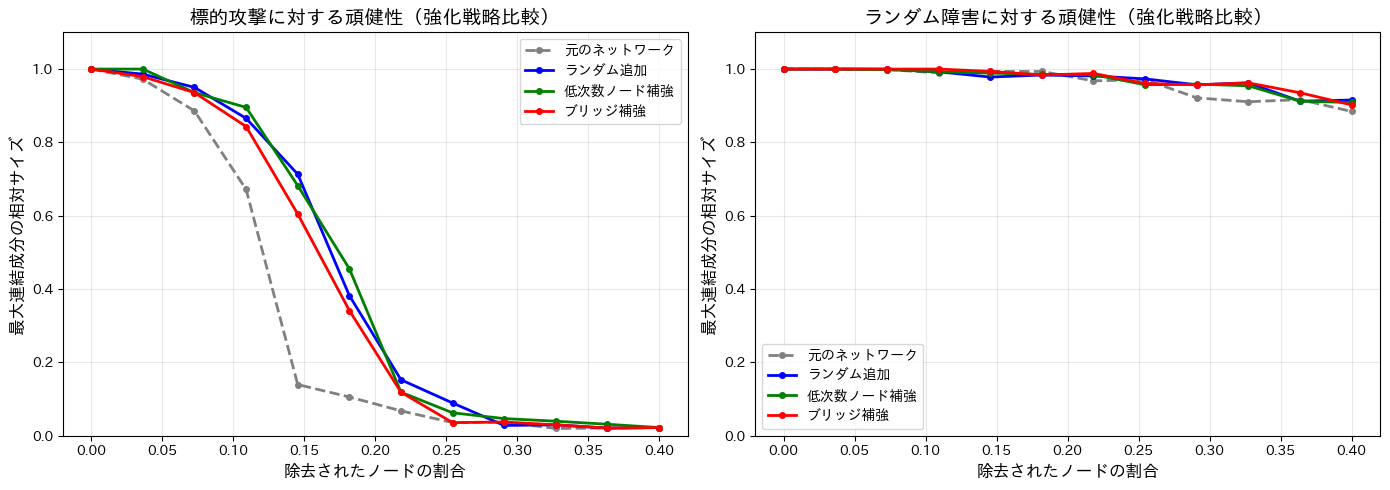

【頑健性強化戦略】

1. 低次数ノードの補強:
   - 周辺ノードの接続性を向上
   - ネットワーク全体の連結性が改善

2. ブリッジの補強:
   - 単一障害点を除去
   - 代替経路を確保

3. ランダムな補強:
   - 最も単純な戦略
   - 特定の脆弱性を狙わないため効果は限定的


In [8]:
def add_redundant_edges(G, n_edges, strategy='random'):
    """
    冗長なエッジを追加して頑健性を強化
    
    Parameters:
    -----------
    G : networkx.Graph
        元のグラフ
    n_edges : int
        追加するエッジ数
    strategy : str
        'random': ランダムにエッジを追加
        'low_degree': 低次数ノード間にエッジを追加
        'bridge': ブリッジを補強
    """
    G_enhanced = G.copy()
    nodes = list(G_enhanced.nodes())
    added = 0
    
    if strategy == 'random':
        attempts = 0
        while added < n_edges and attempts < n_edges * 10:
            u, v = random.sample(nodes, 2)
            if not G_enhanced.has_edge(u, v):
                G_enhanced.add_edge(u, v)
                added += 1
            attempts += 1
    
    elif strategy == 'low_degree':
        # 低次数ノードをソート
        sorted_nodes = sorted(G_enhanced.degree(), key=lambda x: x[1])
        low_degree_nodes = [n for n, d in sorted_nodes[:len(sorted_nodes)//3]]
        
        attempts = 0
        while added < n_edges and attempts < n_edges * 10:
            u, v = random.sample(low_degree_nodes, 2)
            if not G_enhanced.has_edge(u, v):
                G_enhanced.add_edge(u, v)
                added += 1
            attempts += 1
    
    elif strategy == 'bridge':
        # ブリッジ（橋）を見つけて補強
        bridges = list(nx.bridges(G_enhanced))
        
        for u, v in bridges:
            if added >= n_edges:
                break
            # ブリッジの端点の隣接ノード間にエッジを追加
            neighbors_u = set(G_enhanced.neighbors(u)) - {v}
            neighbors_v = set(G_enhanced.neighbors(v)) - {u}
            
            for nu in neighbors_u:
                for nv in neighbors_v:
                    if not G_enhanced.has_edge(nu, nv) and nu != nv:
                        G_enhanced.add_edge(nu, nv)
                        added += 1
                        break
                if added >= n_edges:
                    break
        
        # ブリッジ補強が足りない場合はランダムに追加
        while added < n_edges:
            u, v = random.sample(nodes, 2)
            if not G_enhanced.has_edge(u, v):
                G_enhanced.add_edge(u, v)
                added += 1
    
    return G_enhanced

# 頑健性強化戦略の比較
G_original = nx.barabasi_albert_graph(150, 2)
n_additional_edges = 30

strategies = {
    '元のネットワーク': G_original,
    'ランダム追加': add_redundant_edges(G_original, n_additional_edges, 'random'),
    '低次数ノード補強': add_redundant_edges(G_original, n_additional_edges, 'low_degree'),
    'ブリッジ補強': add_redundant_edges(G_original, n_additional_edges, 'bridge'),
}

fractions = np.linspace(0, 0.4, 12)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['gray', 'blue', 'green', 'red']

# 標的攻撃に対する頑健性
for idx, (name, G) in enumerate(strategies.items()):
    gc_sizes = []
    for f in fractions:
        G_damaged = simulate_targeted_attack(G, f, 'degree')
        if len(G_damaged) > 0:
            gc_sizes.append(get_largest_component_size(G_damaged))
        else:
            gc_sizes.append(0)
    
    linestyle = '--' if idx == 0 else '-'
    axes[0].plot(fractions, gc_sizes, linestyle, color=colors[idx], 
                label=name, linewidth=2, marker='o', markersize=4)

axes[0].set_xlabel('除去されたノードの割合', fontsize=12)
axes[0].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
axes[0].set_title('標的攻撃に対する頑健性（強化戦略比較）', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.1)

# ランダム障害に対する頑健性
for idx, (name, G) in enumerate(strategies.items()):
    gc_means = []
    for f in fractions:
        gc_trial = []
        for _ in range(5):
            G_damaged = simulate_random_failure(G, f)
            if len(G_damaged) > 0:
                gc_trial.append(get_largest_component_size(G_damaged))
            else:
                gc_trial.append(0)
        gc_means.append(np.mean(gc_trial))
    
    linestyle = '--' if idx == 0 else '-'
    axes[1].plot(fractions, gc_means, linestyle, color=colors[idx], 
                label=name, linewidth=2, marker='o', markersize=4)

axes[1].set_xlabel('除去されたノードの割合', fontsize=12)
axes[1].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
axes[1].set_title('ランダム障害に対する頑健性（強化戦略比較）', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("【頑健性強化戦略】")
print("")
print("1. 低次数ノードの補強:")
print("   - 周辺ノードの接続性を向上")
print("   - ネットワーク全体の連結性が改善")
print("")
print("2. ブリッジの補強:")
print("   - 単一障害点を除去")
print("   - 代替経路を確保")
print("")
print("3. ランダムな補強:")
print("   - 最も単純な戦略")
print("   - 特定の脆弱性を狙わないため効果は限定的")

## A15.9 実践例: 空手クラブネットワークの頑健性分析

In [9]:
# 空手クラブネットワークを読み込み
G_karate = nx.karate_club_graph()

print("【空手クラブネットワークの基本情報】")
print(f"ノード数: {G_karate.number_of_nodes()}")
print(f"エッジ数: {G_karate.number_of_edges()}")
print(f"平均次数: {2 * G_karate.number_of_edges() / G_karate.number_of_nodes():.2f}")
print(f"グローバル効率: {nx.global_efficiency(G_karate):.3f}")

# 重要なノードを特定
degree_centrality = nx.degree_centrality(G_karate)
betweenness_centrality = nx.betweenness_centrality(G_karate)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]

print("\n【次数中心性トップ3】")
for node, cent in top_degree:
    print(f"  ノード {node}: {cent:.3f}")

print("\n【媒介中心性トップ3】")
for node, cent in top_betweenness:
    print(f"  ノード {node}: {cent:.3f}")

【空手クラブネットワークの基本情報】
ノード数: 34
エッジ数: 78
平均次数: 4.59
グローバル効率: 0.492

【次数中心性トップ3】
  ノード 33: 0.515
  ノード 0: 0.485
  ノード 32: 0.364

【媒介中心性トップ3】
  ノード 0: 0.438
  ノード 33: 0.304
  ノード 32: 0.145


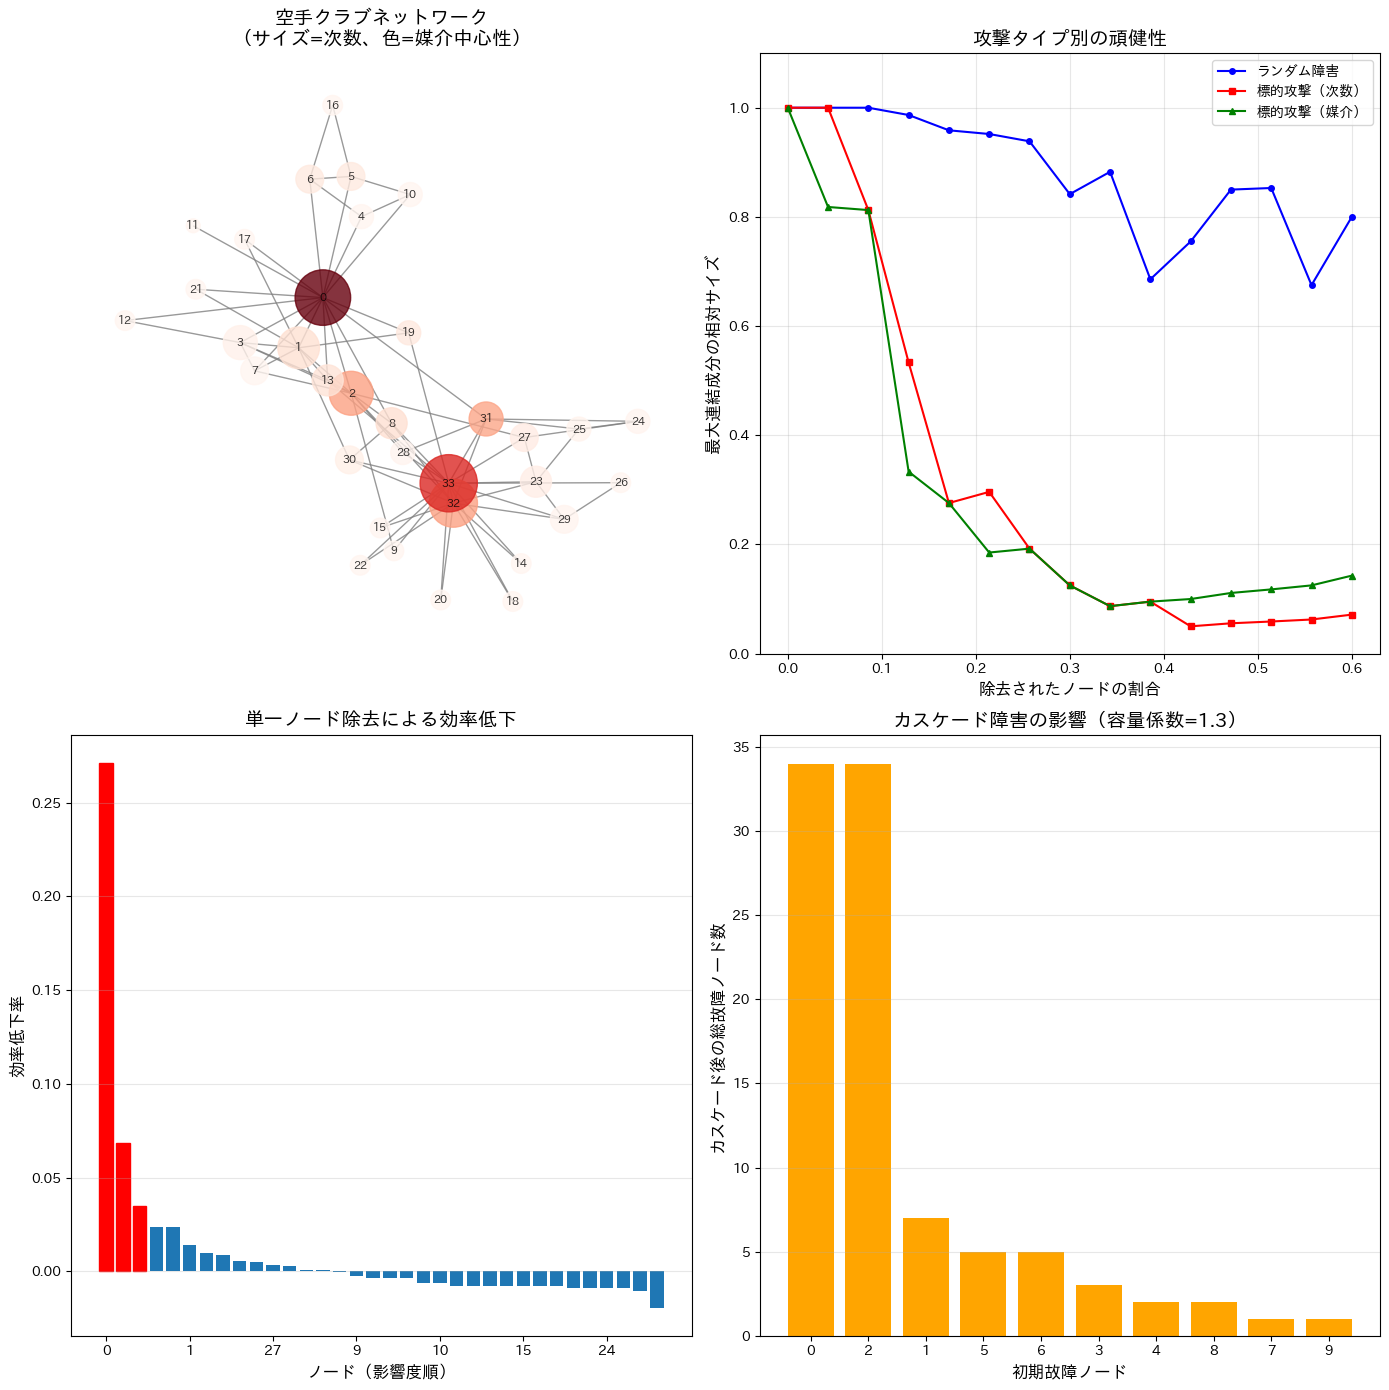

【空手クラブネットワークの脆弱性分析結果】

最も影響力の大きいノード（除去時の効率低下）:
  ノード 0: 27.1%の効率低下
  ノード 33: 6.9%の効率低下
  ノード 2: 3.5%の効率低下

これらのノードは組織のリーダー（ノード0: 指導者、ノード33: 管理者）に対応しており、
その除去がネットワーク全体の機能に大きな影響を与えることがわかります。


In [10]:
# 空手クラブネットワークの可視化と脆弱性分析

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# ネットワークの可視化（次数でノードサイズを変更）
pos = nx.spring_layout(G_karate, seed=42)
degrees = dict(G_karate.degree())
node_sizes = [degrees[n] * 100 for n in G_karate.nodes()]
node_colors = [betweenness_centrality[n] for n in G_karate.nodes()]

nx.draw(G_karate, pos, ax=axes[0, 0],
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.Reds,
        with_labels=True,
        font_size=8,
        edge_color='gray',
        alpha=0.8)
axes[0, 0].set_title('空手クラブネットワーク\n（サイズ=次数、色=媒介中心性）', fontsize=14)

# ランダム障害 vs 標的攻撃
fractions = np.linspace(0, 0.6, 15)

# ランダム障害
gc_random = []
for f in fractions:
    gc_trial = []
    for _ in range(10):
        G_damaged = simulate_random_failure(G_karate, f)
        if len(G_damaged) > 0:
            gc_trial.append(get_largest_component_size(G_damaged))
        else:
            gc_trial.append(0)
    gc_random.append(np.mean(gc_trial))

# 次数ベースの標的攻撃
gc_degree = []
for f in fractions:
    G_damaged = simulate_targeted_attack(G_karate, f, 'degree')
    if len(G_damaged) > 0:
        gc_degree.append(get_largest_component_size(G_damaged))
    else:
        gc_degree.append(0)

# 媒介中心性ベースの標的攻撃
gc_between = []
for f in fractions:
    G_damaged = simulate_targeted_attack(G_karate, f, 'betweenness')
    if len(G_damaged) > 0:
        gc_between.append(get_largest_component_size(G_damaged))
    else:
        gc_between.append(0)

axes[0, 1].plot(fractions, gc_random, 'b-o', label='ランダム障害', markersize=4)
axes[0, 1].plot(fractions, gc_degree, 'r-s', label='標的攻撃（次数）', markersize=4)
axes[0, 1].plot(fractions, gc_between, 'g-^', label='標的攻撃（媒介）', markersize=4)
axes[0, 1].set_xlabel('除去されたノードの割合', fontsize=12)
axes[0, 1].set_ylabel('最大連結成分の相対サイズ', fontsize=12)
axes[0, 1].set_title('攻撃タイプ別の頑健性', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1.1)

# 単一ノード除去の影響
single_node_impact = {}
original_efficiency = nx.global_efficiency(G_karate)

for node in G_karate.nodes():
    G_temp = G_karate.copy()
    G_temp.remove_node(node)
    new_efficiency = nx.global_efficiency(G_temp)
    impact = (original_efficiency - new_efficiency) / original_efficiency
    single_node_impact[node] = impact

sorted_impact = sorted(single_node_impact.items(), key=lambda x: x[1], reverse=True)
nodes_sorted = [n for n, _ in sorted_impact]
impacts = [i for _, i in sorted_impact]

bars = axes[1, 0].bar(range(len(nodes_sorted)), impacts)
# 上位3ノードを強調
for i in range(3):
    bars[i].set_color('red')
axes[1, 0].set_xlabel('ノード（影響度順）', fontsize=12)
axes[1, 0].set_ylabel('効率低下率', fontsize=12)
axes[1, 0].set_title('単一ノード除去による効率低下', fontsize=14)
axes[1, 0].set_xticks(range(0, len(nodes_sorted), 5))
axes[1, 0].set_xticklabels([str(nodes_sorted[i]) for i in range(0, len(nodes_sorted), 5)])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# カスケード障害の分析
cascade_data = {}
for node in list(G_karate.nodes())[:10]:  # 上位10ノードのみ分析
    history, failed, _ = simulate_cascade_failure(G_karate, node, capacity_factor=1.3)
    cascade_data[node] = len(failed)

sorted_cascade = sorted(cascade_data.items(), key=lambda x: x[1], reverse=True)
nodes_c = [str(n) for n, _ in sorted_cascade]
failures = [f for _, f in sorted_cascade]

axes[1, 1].bar(range(len(nodes_c)), failures, color='orange')
axes[1, 1].set_xlabel('初期故障ノード', fontsize=12)
axes[1, 1].set_ylabel('カスケード後の総故障ノード数', fontsize=12)
axes[1, 1].set_title('カスケード障害の影響（容量係数=1.3）', fontsize=14)
axes[1, 1].set_xticks(range(len(nodes_c)))
axes[1, 1].set_xticklabels(nodes_c)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("【空手クラブネットワークの脆弱性分析結果】")
print("")
print(f"最も影響力の大きいノード（除去時の効率低下）:")
for node, impact in sorted_impact[:3]:
    print(f"  ノード {node}: {impact:.1%}の効率低下")
print("")
print("これらのノードは組織のリーダー（ノード0: 指導者、ノード33: 管理者）に対応しており、")
print("その除去がネットワーク全体の機能に大きな影響を与えることがわかります。")

## A15.10 練習問題

### 練習問題1: 異なる攻撃戦略の比較

スケールフリーネットワーク（n=200, m=3）を生成し、以下の3つの攻撃戦略の効果を比較してください：
1. 次数中心性に基づく攻撃
2. 媒介中心性に基づく攻撃
3. 固有ベクトル中心性に基づく攻撃

ノードを20%除去した後の最大連結成分サイズとグローバル効率を比較し、どの攻撃戦略が最も効果的かを分析してください。

<details>
<summary>解答例</summary>

```python
# スケールフリーネットワークの生成
G = nx.barabasi_albert_graph(200, 3)

print("元のネットワーク:")
print(f"  ノード数: {G.number_of_nodes()}")
print(f"  エッジ数: {G.number_of_edges()}")
print(f"  グローバル効率: {nx.global_efficiency(G):.3f}")
print()

# 異なる攻撃戦略でテスト
removal_fraction = 0.2
attack_strategies = ['degree', 'betweenness', 'eigenvector']
results = {}

for strategy in attack_strategies:
    G_attacked = simulate_targeted_attack(G, removal_fraction, strategy)
    
    gc_size = get_largest_component_size(G_attacked) if len(G_attacked) > 0 else 0
    efficiency = get_global_efficiency(G_attacked) if len(G_attacked) > 0 else 0
    
    results[strategy] = {
        'gc_size': gc_size,
        'efficiency': efficiency
    }

print(f"20%のノードを除去した後の結果:")
print()
print(f"{'攻撃戦略':<20} {'最大連結成分':>15} {'グローバル効率':>15}")
print("-" * 52)
for strategy, data in results.items():
    print(f"{strategy:<20} {data['gc_size']:>15.3f} {data['efficiency']:>15.3f}")

# 最も効果的な攻撃戦略を特定
best_attack = min(results.items(), key=lambda x: x[1]['gc_size'])
print()
print(f"最も効果的な攻撃戦略: {best_attack[0]}")
print(f"  （最大連結成分が最も小さくなる）")
```
</details>

In [11]:
# 練習問題1の解答欄


### 練習問題2: ネットワーク構造と臨界閾値

以下の3種類のネットワーク（各n=300）について、ランダム障害に対する臨界閾値を推定し、理論値と比較してください：
1. Erdős-Rényiランダムグラフ（p=0.04）
2. Barabási-Albertネットワーク（m=4）
3. 正則グラフ（k=8）

ヒント: ランダムネットワークの臨界閾値は fc ≈ 1 - 1/<k> で近似できます。

<details>
<summary>解答例</summary>

```python
n = 300

networks = {
    'Erdős-Rényi (p=0.04)': nx.erdos_renyi_graph(n, 0.04),
    'Barabási-Albert (m=4)': nx.barabasi_albert_graph(n, 4),
    '正則グラフ (k=8)': nx.random_regular_graph(8, n),
}

print(f"{'ネットワーク':<25} {'平均次数':>10} {'理論的fc':>12} {'推定fc':>12}")
print("-" * 62)

for name, G in networks.items():
    # 平均次数
    avg_degree = 2 * G.number_of_edges() / G.number_of_nodes()
    
    # 理論的な臨界閾値
    theoretical_fc = 1 - 1 / avg_degree
    
    # シミュレーションによる推定
    estimated_fc, _, _, _ = find_percolation_threshold(G, 'random', n_trials=5)
    
    print(f"{name:<25} {avg_degree:>10.2f} {theoretical_fc:>12.3f} {estimated_fc:>12.3f}")

print()
print("注: スケールフリーネットワークは理論上 fc → 1 となり、")
print("    ランダム障害に対して非常に頑健です。")
```
</details>

In [12]:
# 練習問題2の解答欄


### 練習問題3: カスケード障害の緩和策

以下の条件でカスケード障害をシミュレートし、緩和策の効果を分析してください：

1. スケールフリーネットワーク（n=100, m=2）を生成
2. 最も次数の高いノード（ハブ）の故障からカスケードを開始
3. 容量係数を1.2, 1.5, 2.0, 3.0と変化させて、最終的な故障ノード数を比較
4. カスケードを50%以下に抑えるために必要な最小容量係数を推定

<details>
<summary>解答例</summary>

```python
G = nx.barabasi_albert_graph(100, 2)

# ハブを特定
hub = max(G.degree(), key=lambda x: x[1])[0]
hub_degree = G.degree(hub)

print(f"ネットワーク情報:")
print(f"  ノード数: {G.number_of_nodes()}")
print(f"  ハブノード: {hub} (次数: {hub_degree})")
print()

# 異なる容量係数でテスト
capacity_factors = [1.2, 1.5, 2.0, 2.5, 3.0]
results = []

print(f"{'容量係数':>10} {'故障ノード数':>15} {'故障率':>10}")
print("-" * 38)

for cf in capacity_factors:
    history, failed, _ = simulate_cascade_failure(G, hub, capacity_factor=cf)
    failure_rate = len(failed) / len(G)
    results.append((cf, len(failed), failure_rate))
    print(f"{cf:>10.1f} {len(failed):>15} {failure_rate:>10.1%}")

# 50%以下に抑えるための最小容量係数を推定
for cf, n_failed, rate in results:
    if rate <= 0.5:
        print(f"\n故障率を50%以下に抑えるための最小容量係数: 約 {cf}")
        break
else:
    print("\nテストした容量係数では50%以下に抑えられませんでした。")
    print("より大きな容量係数が必要です。")

# 可視化
plt.figure(figsize=(10, 5))
cfs = [r[0] for r in results]
rates = [r[2] for r in results]
plt.plot(cfs, rates, 'o-', markersize=8, linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', label='50%閾値')
plt.xlabel('容量係数', fontsize=12)
plt.ylabel('最終故障率', fontsize=12)
plt.title('容量係数とカスケード障害の関係', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
```
</details>

In [13]:
# 練習問題3の解答欄


## A15.11 章のまとめ

この章では、ネットワークの頑健性について学びました：

### 重要な概念

1. **頑健性（Robustness）**
   - ネットワークが障害や攻撃に対して機能を維持する能力
   - 最大連結成分サイズとグローバル効率で測定

2. **障害の種類**
   - ランダム障害：偶発的な故障
   - 標的攻撃：重要ノードへの意図的な攻撃

3. **ネットワーク構造の影響**
   - スケールフリー：ランダム障害に強く、標的攻撃に弱い
   - ランダム：両方の障害に対して同程度の脆弱性
   - スモールワールド：中間的な頑健性

4. **パーコレーション理論**
   - 臨界閾値：ネットワークが崩壊する障害の割合
   - fc = 1 - 1/<k>（ランダムネットワークの場合）

5. **カスケード障害**
   - 一つの障害が連鎖的に広がる現象
   - 容量と負荷のバランスが重要

### 実践的な応用

- インフラネットワーク（電力、通信）の設計
- サプライチェーンの脆弱性分析
- 社会ネットワークの安定性評価
- サイバーセキュリティ対策

### 頑健性強化の戦略

1. 冗長な接続の追加
2. 単一障害点（ブリッジ）の除去
3. 低次数ノードの接続性向上
4. 十分な余裕容量の確保